In [1]:
import healpy as hp
import numpy as np
import h5py, os, sys

from matplotlib import pyplot as plt 
plt.rcParams['image.cmap'] = 'cividis'

In [2]:
data_path = "/data2/shared/shubh/projected_probes_maps_baryonified512.h5"
with h5py.File(data_path, "r") as f:
    hp_kappa = f["kg"]["stage3_lensing1"][:]

print(hp.nside2resol(hp.get_nside(hp_kappa), arcmin=True))

6.870972823634812


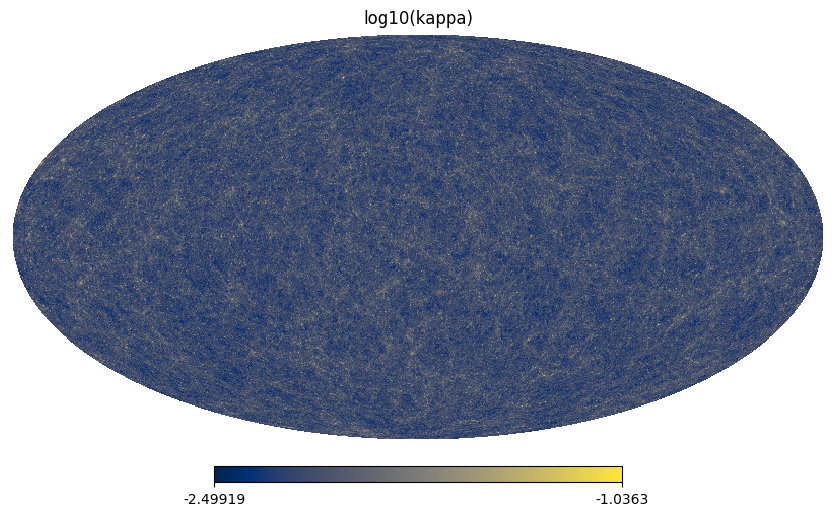

In [3]:
hp.mollview(np.log10(hp_kappa), title="log10(kappa)")

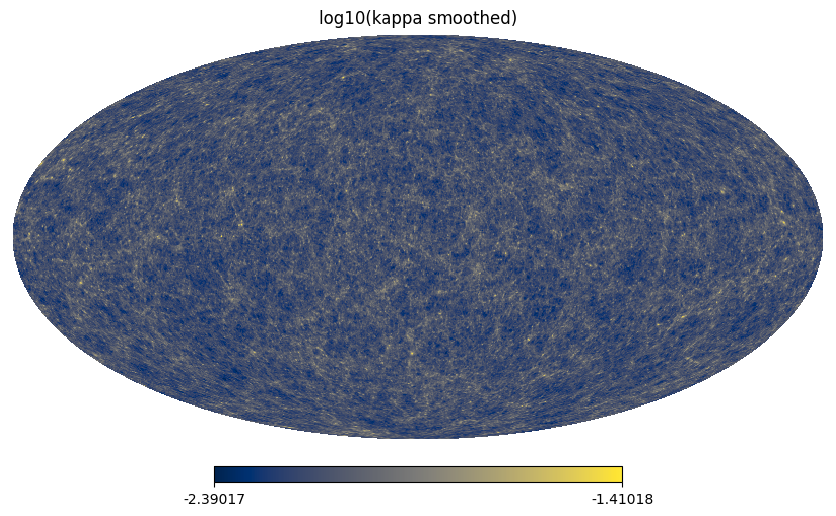

In [4]:
# Apply Gaussian smoothing to the HEALPix map
filter_size_arcmin = 20  # Smoothing scale in arcmin
fwhm = np.radians(filter_size_arcmin / 60)  # FWHM of the Gaussian filter in radians
hp_kappa_smoothed = hp.sphtfunc.smoothing(hp_kappa, fwhm=fwhm)

hp.mollview(np.log10(hp_kappa_smoothed), title="log10(kappa smoothed)")

In [5]:
def find_peaks(healpix_map):
    nside = hp.get_nside(healpix_map)
    npix = hp.nside2npix(nside)
    
    # Get the indices of all the pixels
    pixel_indices = np.arange(npix)
    
    # Get the values of the neighboring pixels for all pixels
    neighbor_indices = hp.get_all_neighbours(nside, pixel_indices)
    neighbor_values = healpix_map[neighbor_indices]
    
    neighbor_values = np.transpose(neighbor_values, (1, 0))
    healpix_map = healpix_map[:, None]
    
    # Find the peaks by comparing the values of each pixel with its neighbors
    peaks_mask = np.all(healpix_map > neighbor_values, axis=1)
    peak_indices = pixel_indices[peaks_mask]
    
    return peak_indices

peaks = find_peaks(hp_kappa_smoothed)

print(len(peaks), len(hp_kappa_smoothed), len(peaks)/len(hp_kappa_smoothed))


54958 3145728 0.017470677693684895


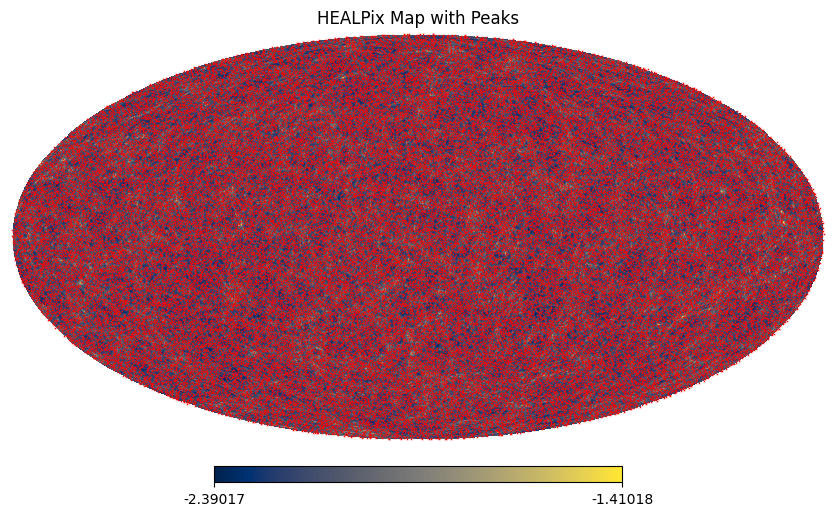

In [6]:
hp.mollview(np.log10(hp_kappa_smoothed), title='HEALPix Map with Peaks')
hp.visufunc.projscatter(hp.pix2ang(hp.get_nside(hp_kappa_smoothed), peaks, lonlat=True),
                        marker='x', color='red', s=0.1, coord='C', lonlat=True)
plt.show()

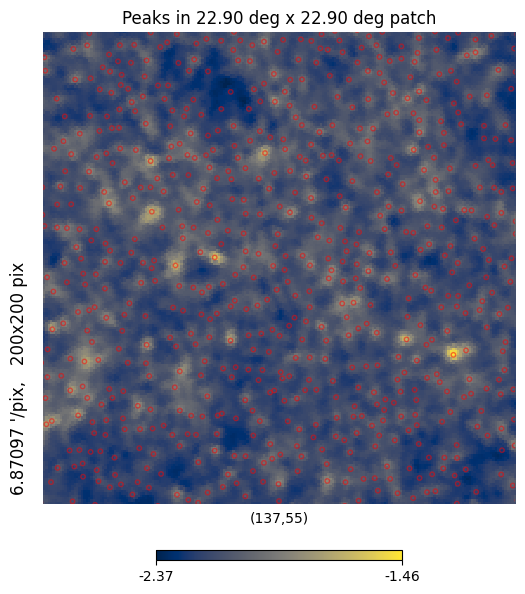

In [7]:
# Define the center of the gnomic projection
center_ra = 137.0  # Center Right Ascension in degrees
center_dec = 55.0  # Center Declination in degrees
res = hp.nside2resol(hp.get_nside(hp_kappa_smoothed), arcmin=True)  # Pixel resolution in arcmin

# Plotting the gnomic projection patch
hp.gnomview(np.log10(hp_kappa_smoothed), rot=(center_ra, center_dec), xsize=200, ysize=200, reso=res, \
                title=f"Peaks in {200*res/60:.2f} deg x {200*res/60:.2f} deg patch")

# Plotting the peaks on the gnomonic patch
lon, lat = hp.pix2ang(hp.get_nside(hp_kappa_smoothed), peaks, lonlat=True)
hp.projscatter(lon, lat, marker='o', color='red', facecolors='none', s=10, lw=1, alpha=0.5, lonlat=True)

plt.show()